In [50]:
import numpy as np
import random
import torch
import torchvision
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    

def get_unique_classes(dataset):
    unique_classes = set()
    for img, mask in dataset:
        classes = list(mask.getcolors())
        for count, pixel_value in classes:
            unique_classes.add(pixel_value)
    
    return unique_classes

# 데이터셋 다운로드 및 생성
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])

mask_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224), interpolation=Image.NEAREST), 
    torchvision.transforms.ToTensor()
])

voc_dataset = VOCSegmentation(root='~/.data', year='2012', image_set='train', download=False, transform=transforms, target_transform=mask_transforms)
voc_dataloader = torch.utils.data.DataLoader(voc_dataset, batch_size=10, shuffle=True)

/home/suncheol/code/FedTest/.venv/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [51]:
def mask_img_to_target(mask, num_classes=20):
    # get colors
    mask = to_pil_image(mask)
    colors = list(mask.getcolors())
    torch_target = torch.zeros(num_classes)
    for count, pixel_value in colors:
        if pixel_value in [0, 255]: # 0 is background, 255 is border,
            continue
        torch_target[pixel_value - 1] = 1
    return torch_target

def masks_to_targets(masks, num_classes=20):
    targets = []
    for mask in masks:
        targets.append(mask_img_to_target(mask, num_classes))
    return torch.stack(targets)

images, masks = iter(voc_dataloader).next()
labels = masks_to_targets(masks)

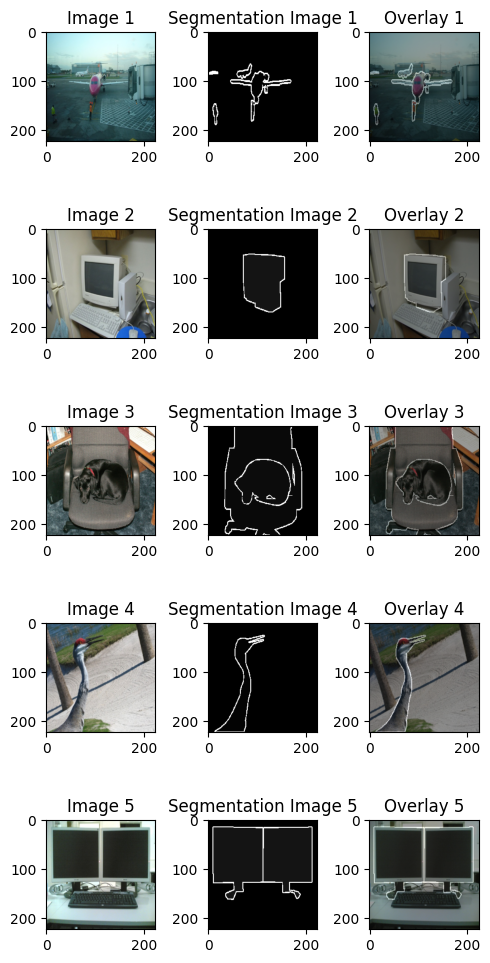

10


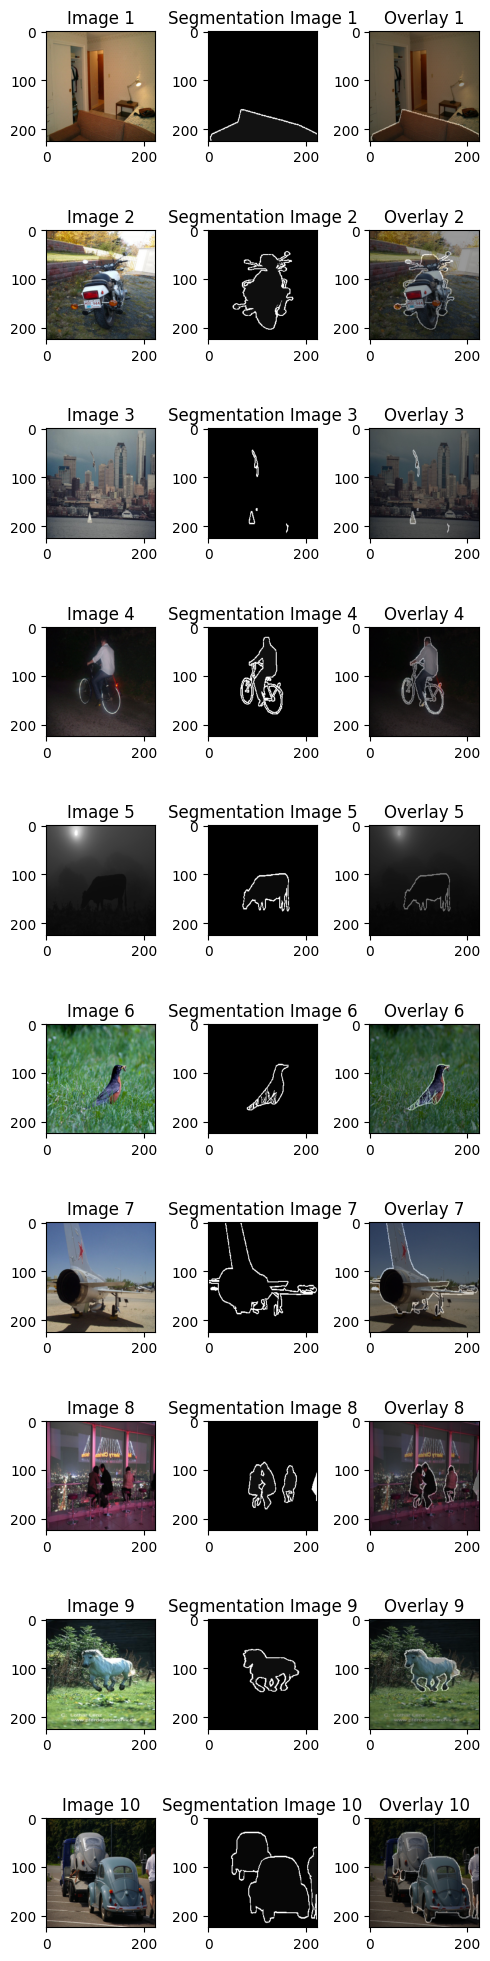

In [52]:
def display_images(dataset, num_images=5):
    fig, ax = plt.subplots(num_images, 3, figsize=(5, num_images * 2))
    for i in range(num_images):
        # 이미지 및 마스크 가져오기
        img, mask = dataset[i]

        # 이미지 및 마스크 표시
        ax[i, 0].imshow(img.permute(1, 2, 0))
        ax[i, 0].set_title(f"Image {i + 1}")
        ax[i, 1].imshow(mask.permute(1, 2, 0), cmap='gray')
        ax[i, 1].set_title(f"Segmentation Image {i + 1}")
        # overlay segmentation mask on image
        ax[i, 2].imshow(img.permute(1, 2, 0))
        ax[i, 2].imshow(mask.permute(1, 2, 0), alpha=0.4, cmap='gray')
        ax[i, 2].set_title(f"Overlay {i + 1}")
        
    plt.tight_layout()
    plt.show()

display_images(voc_dataset)
def display_images(images, masks):
    num_images = len(images)
    print(num_images)
    fig, ax = plt.subplots(num_images, 3, figsize=(5, num_images * 2))
    for i in range(num_images):
        # 이미지 및 마스크 가져오기
        img = images[i].permute(1, 2, 0)
        mask = masks[i].permute(1, 2, 0)

        # 이미지 및 마스크 표시
        ax[i, 0].imshow(img)
        ax[i, 0].set_title(f"Image {i + 1}")
        ax[i, 1].imshow(mask, cmap='gray')
        ax[i, 1].set_title(f"Segmentation Image {i + 1}")
        # overlay segmentation mask on image
        ax[i, 2].imshow(img)
        ax[i, 2].imshow(mask, alpha=0.4, cmap='gray')
        ax[i, 2].set_title(f"Overlay {i + 1}")
    
    plt.tight_layout()
    plt.savefig('test.png')
    plt.show()
    
# 데이터셋에서 이미지 및 마스크 표시
display_images(images, masks)

In [53]:
# %%
import sys
sys.path.append('..')
import utils
import os
import pathlib
import argparse
from tensorboardX import SummaryWriter
import logging
from datetime import datetime
import torch 
import mymodels 
import mydataset 
from torch.utils.data import DataLoader
from utils.myfed import *
import yaml
# %%

In [54]:
yamlfilepath = pathlib.Path.cwd().parent.joinpath('config.yaml')
args = yaml.load(yamlfilepath.open('r'), Loader=yaml.FullLoader)
args = argparse.Namespace(**args)
args.datapath = "~/.data"
args.batchsize = 200
os.environ['CUDA_VISIBLE_DEVICES']=args.gpu
# 1. data
args.datapath = os.path.expanduser(args.datapath)

if args.dataset == 'cifar10':
    publicdata = 'cifar100'
    args.N_class = 10
elif args.dataset == 'cifar100':
    publicdata = 'imagenet'
    args.N_class = 100
elif args.dataset == 'pascal_voc2012':
    publicdata = 'mscoco'
    args.N_class = 20

In [55]:
args.model_name = 'vit_tiny_patch16_224'
net = mymodels.define_model(modelname=args.model_name, num_classes=args.N_class)
net 

DataParallel(
  (module): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate=none)
          (drop1): Dropout(p=0.0, inplace=False)
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop2): Dropout(p=0.0, inplace=False)
   

In [56]:
n = 0
loadname = os.path.join("/home/suncheol/code/VFL/FedMAD/checkpoints_backup/pascal_voc2012/a1.0+sd1+e300+b16+lkl", str(n)+'.pt')
if os.path.exists(loadname):
    localmodels = torch.load(loadname)
    #self.localmodels[n].load_state_dict(self.best_statdict, strict=True)
    logging.info(f'Loading Local{n}......')
    print('filepath : ', loadname)
    utils.load_dict(loadname, net)

In [57]:
loadname = os.path.join("/home/suncheol/code/FedTest/FedMAD/checkpoints/pascal_voc2012/a1.0+sd1+e300+b16+lkl/model-0.pth")
loadname = os.path.join("/home/suncheol/code/FedTest/FedMAD2/checkpoints/pascal_voc2012/a1.0+sd1+e300+b128+lkl+slmha/oneshot_c1_q0.0_n0.0/q0.0_n0.0_ADAM_b128_5e-05_200_5e-05_m0.9_e10_0.66.pt")
# loadname = os.path.join("/home/suncheol/code/FedTest/pytorch-models/checkpoint/pascal_voc_vit_tiny_patch16_224_0.0001_-1/ckpt.pth")
if os.path.exists(loadname):
    localmodels = torch.load(loadname)
    #self.localmodels[n].load_state_dict(self.best_statdict, strict=True)
    logging.info(f'Loading Local......')
    print('filepath : ', loadname)
    utils.load_dict(loadname, net)

filepath :  /home/suncheol/code/FedTest/FedMAD2/checkpoints/pascal_voc2012/a1.0+sd1+e300+b128+lkl+slmha/oneshot_c1_q0.0_n0.0/q0.0_n0.0_ADAM_b128_5e-05_200_5e-05_m0.9_e10_0.66.pt


In [58]:
import copy
models = []
for i in range(0, 5):
    model = copy.deepcopy(net)
    loadname = os.path.join(f"/home/suncheol/code/FedTest/FedMAD2/checkpoints/pascal_voc2012/a1.0+sd1+e300+b128+lkl+slmha/model-{i}.pth")
    # loadname = os.path.join(f"/home/suncheol/code/FedTest/pytorch-models/checkpoint/pascal_voc_vit_tiny_patch16_224_0.0001_{i}/ckpt.pth")
    if os.path.exists(loadname):
        localmodels = torch.load(loadname)
        #self.localmodels[n].load_state_dict(self.best_statdict, strict=True)
        logging.info(f'Loading Local......', 'filepath : ', loadname)
        utils.load_dict(loadname, model)
    models.append(model)

In [59]:
VOC_CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
# multi label to multi captions
def multi_label_to_multi_captions(labels):
    captions = []
    for label in labels:
        caption = []
        for i in range(len(label)):
            if label[i] == 1:
                caption.append(VOC_CLASSES[i])
        captions.append(caption)
    return captions
labels = multi_label_to_multi_captions(labels)

In [61]:
grad_cam_images = []
pred_labels = []
for model in models:
    grad_cam_images.append(model.module.get_class_activation_map(images, labels))
    m = torch.nn.Sigmoid()
    th = 0.3
    outputs = m(model(images)).detach().cpu().numpy()
    outputs[outputs > th] = 1
    outputs[outputs <= th] = 0
    pred = multi_label_to_multi_captions(outputs)
    pred_labels.append(pred)

grad_cam_images = torch.stack([torch.tensor(grad_cam_images[i]) for i in range(len(grad_cam_images))])
grad_cam_images.shape # n_clients * b * 224 * 224

# grayscale_cam = net.module.get_class_activation_map(images, labels)
central_model = copy.deepcopy(net)
central_grad_cam_image = central_model.module.get_class_activation_map(images, labels)
m = torch.nn.Sigmoid()
th = 0.3
outputs = m(central_model(images)).detach().cpu().numpy()
outputs[outputs > th] = 1
outputs[outputs <= th] = 0
central_pred_labels = multi_label_to_multi_captions(outputs)


In [62]:
union_cam = torch.max(grad_cam_images, dim=0)[0]
intersection_cam = torch.min(grad_cam_images, dim=0)[0]
union_cam.cpu().shape

torch.Size([10, 224, 224])

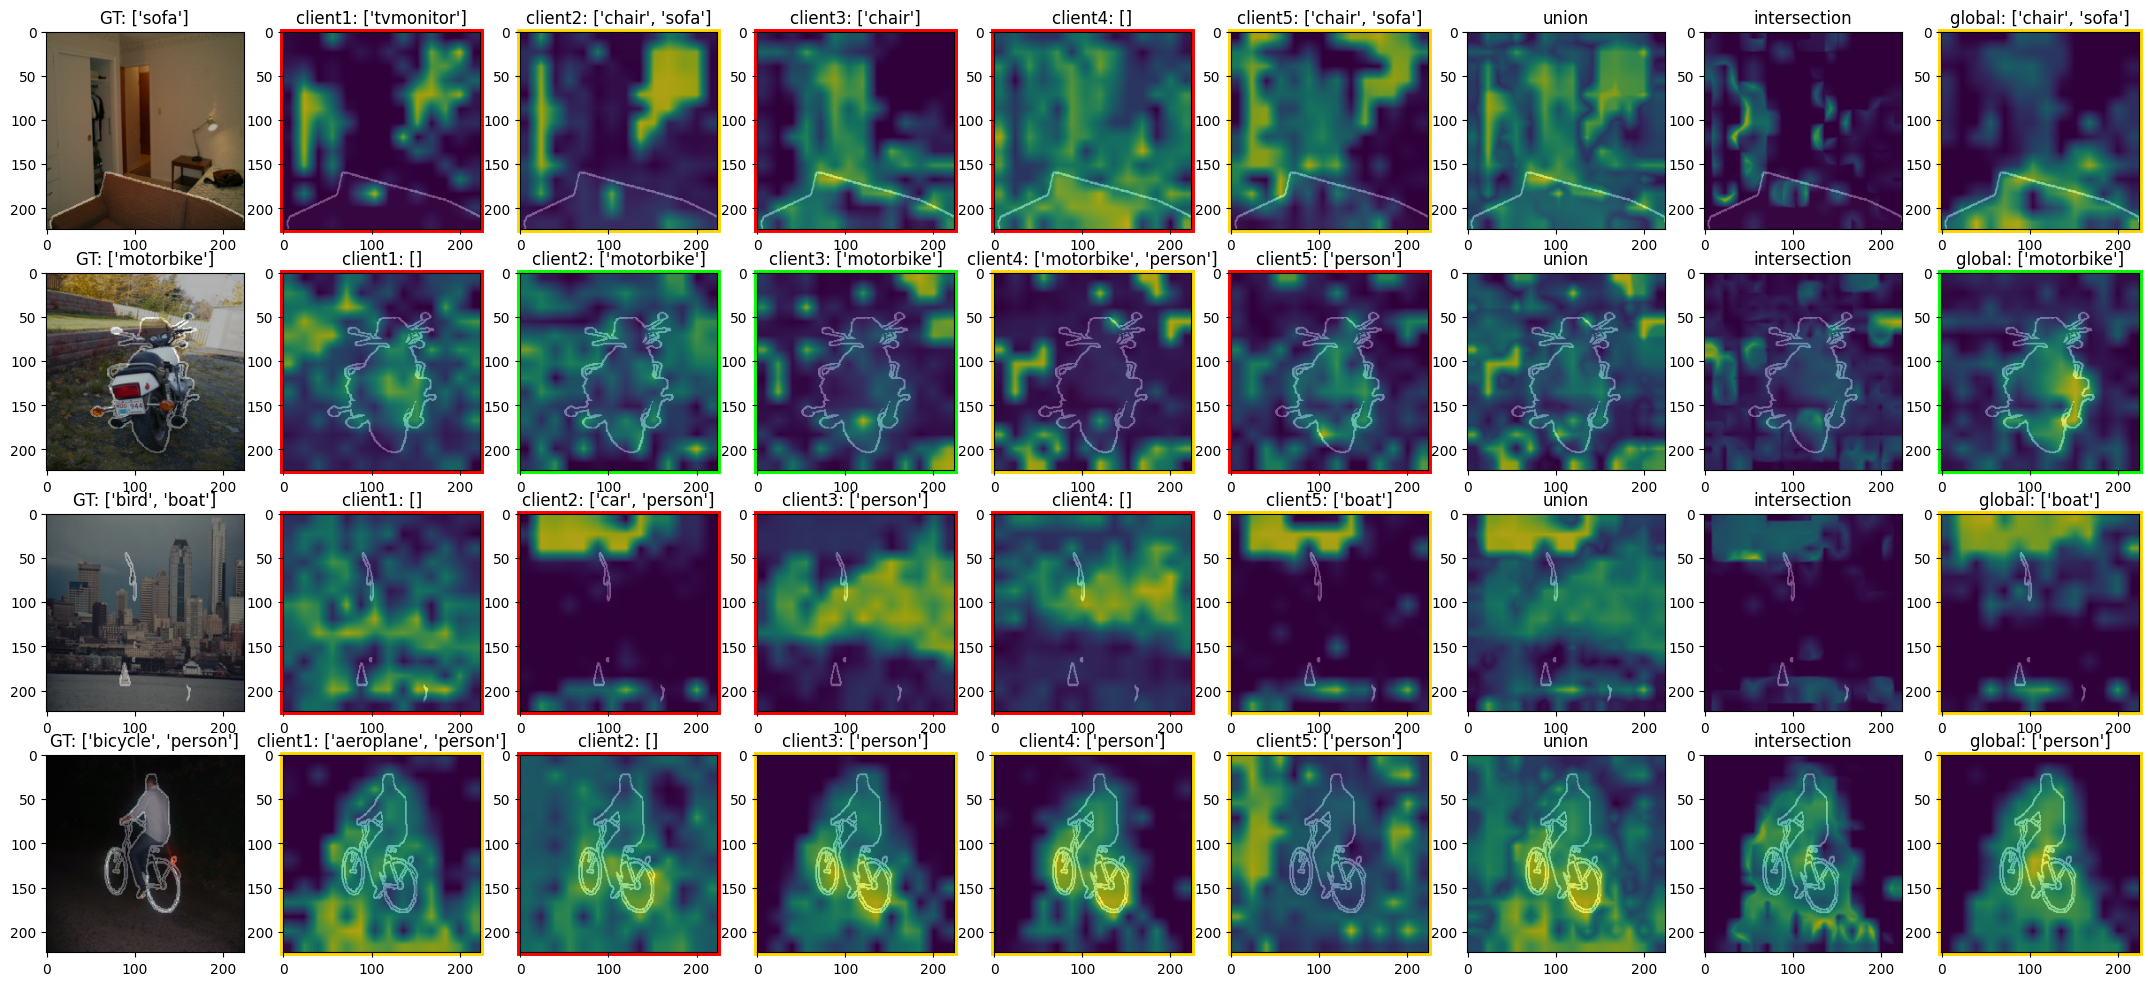

In [63]:
%matplotlib inline
def get_border_color(true_label, pred_label):
    if pred_label == true_label:
        return 'lime'  # green
    elif set(pred_label) & set(true_label):
        return 'gold'  # yellow
    else:
        return 'red'

row = 4
col = 9
clients = 5
extra_plots = 3  # union, intersection, global

import matplotlib.pyplot as plt
plt.figure(figsize=(3 * col, 3 * row))

for j in range(row):
    true_label = labels[j]
    for i in range(clients + extra_plots + 1):
        ax = plt.subplot(row, col, j * col + i + 1)
        # print(i, j)
        if i == 0:
            img = images[j].cpu().permute(1, 2, 0)
            mask = masks[j].permute(1, 2, 0).cpu()
            plt.imshow(img)
            plt.imshow(mask, alpha=0.3, cmap='gray')
            plt.title(f'GT: {true_label}')
        elif i <= clients:
            img = grad_cam_images[i - 1].cpu()[j]
            pred_label = pred_labels[i - 1][j]
            border_color = get_border_color(true_label, pred_label)
            plt.imshow(img)
            plt.imshow(mask, alpha=0.3, cmap='gray')
            # set border color
            ax.patch.set_edgecolor(border_color)
            ax.patch.set_linewidth(5)
            plt.title(f'client{i}: {pred_label}')
        elif i == clients + 1:
            img = union_cam.cpu()[j]
            plt.imshow(img)
            plt.imshow(mask, alpha=0.3, cmap='gray')
            plt.title('union')
        elif i == clients + 2:
            img = intersection_cam.cpu()[j]
            plt.imshow(img)
            plt.imshow(mask, alpha=0.3, cmap='gray')
            plt.title('intersection')
        elif i == clients + 3:
            img = central_grad_cam_image[j]
            border_color = get_border_color(true_label, central_pred_labels[j])
            plt.imshow(img)
            plt.imshow(mask, alpha=0.3, cmap='gray')
            plt.title(f'global: {central_pred_labels[j]}')
            ax.patch.set_edgecolor(border_color)
            ax.patch.set_linewidth(5)
        # plt.gca().set_xticks([])
        # plt.gca().set_yticks([])
        # plt.gca().spines['top'].set_visible(False)
        # plt.gca().spines['right'].set_visible(False)
        # plt.gca().spines['bottom'].set_visible(False)
        # plt.gca().spines['left'].set_visible(False)

plt.savefig('grad_cam.png')
plt.show()
# plt.tight_layout()

In [65]:
correct_dict = {}
for idx, (true_label, central_pred) in enumerate(zip(labels, central_pred_labels)):
    correct_clients_count = sum(client_pred[idx] == true_label for client_pred in pred_labels)
    correct_central = central_pred == true_label
    correct_dict[idx] = (correct_clients_count, correct_central)

# correct_dict to dataframe
import pandas as pd
df = pd.DataFrame.from_dict(correct_dict, orient='index', columns=['correct_clients_count', 'correct_central'])
df = df.pivot_table(index='correct_clients_count', columns='correct_central', aggfunc=len, fill_value=0)
df.T

correct_clients_count  0  1  2  3  4  5
correct_central                        
False                  3  2  0  0  0  0
True                   0  0  1  1  1  2

In [66]:
correct_dict

{0: (0, False),
 1: (2, True),
 2: (0, False),
 3: (0, False),
 4: (1, False),
 5: (4, True),
 6: (5, True),
 7: (5, True),
 8: (1, False),
 9: (3, True)}

In [33]:
def find_wrong_clients_correct_central(true_labels, client_pred_labels, central_pred_labels):
    result_indices = []
    for idx, (true_label, central_pred) in enumerate(zip(true_labels, central_pred_labels)):
        if sum(client_pred[idx] == true_label for client_pred in client_pred_labels) < 2 and central_pred == true_label:
            result_indices.append(idx)
    return result_indices

def find_correct_clients_wrong_central(true_labels, client_pred_labels, central_pred_labels):
    result_indices = []
    for idx, (true_label, central_pred) in enumerate(zip(true_labels, central_pred_labels)):
        # if all(client_pred[idx] == true_label for client_pred in client_pred_labels) and central_pred != true_label:
        #     result_indices.append(idx)
        # more than 3 clients are correct and central is wrong
        if sum(client_pred[idx] == true_label for client_pred in client_pred_labels) > 3 and central_pred != true_label:
            result_indices.append(idx)
            
    return result_indices

# Example usage
wrong_clients_correct_central_indices = find_wrong_clients_correct_central(labels, pred_labels, central_pred_labels[0])
print("Wrong clients, correct central indices:", wrong_clients_correct_central_indices)

correct_clients_wrong_central_indices = find_correct_clients_wrong_central(labels, pred_labels, central_pred_labels[0])
print("Correct clients, wrong central indices:", correct_clients_wrong_central_indices)

Wrong clients, correct central indices: []
Correct clients, wrong central indices: []


In [70]:
def dice_score(y_pred, y_true, smooth=1):
    if torch.max(y_pred) > 1:
        print("y_pred should be in range [0, 1]")
    if torch.max(y_true) > 1:
        print("y_true should be in range [0, 1]")
    y_pred = y_pred.float()
    y_true = y_true.float()
    dice_loss = (2 * (y_pred * y_true).sum() + smooth) / ((y_pred + y_true).sum() + smooth)
    return dice_loss

dice_scores = []
for i in range(10):
    central_grad_cam = torch.tensor(central_grad_cam_image[i] >0.1).unsqueeze(0).cpu()
    mask_img = masks[i].unsqueeze(0).cpu() > 0
    ds = dice_score(central_grad_cam, mask_img)
    dice_scores.append(ds)

print(dice_scores)    

[tensor(0.4170), tensor(0.4948), tensor(0.0319), tensor(0.3554), tensor(0.2825), tensor(0.0112), tensor(0.0379), tensor(0.2643), tensor(0.0197), tensor(0.5641)]


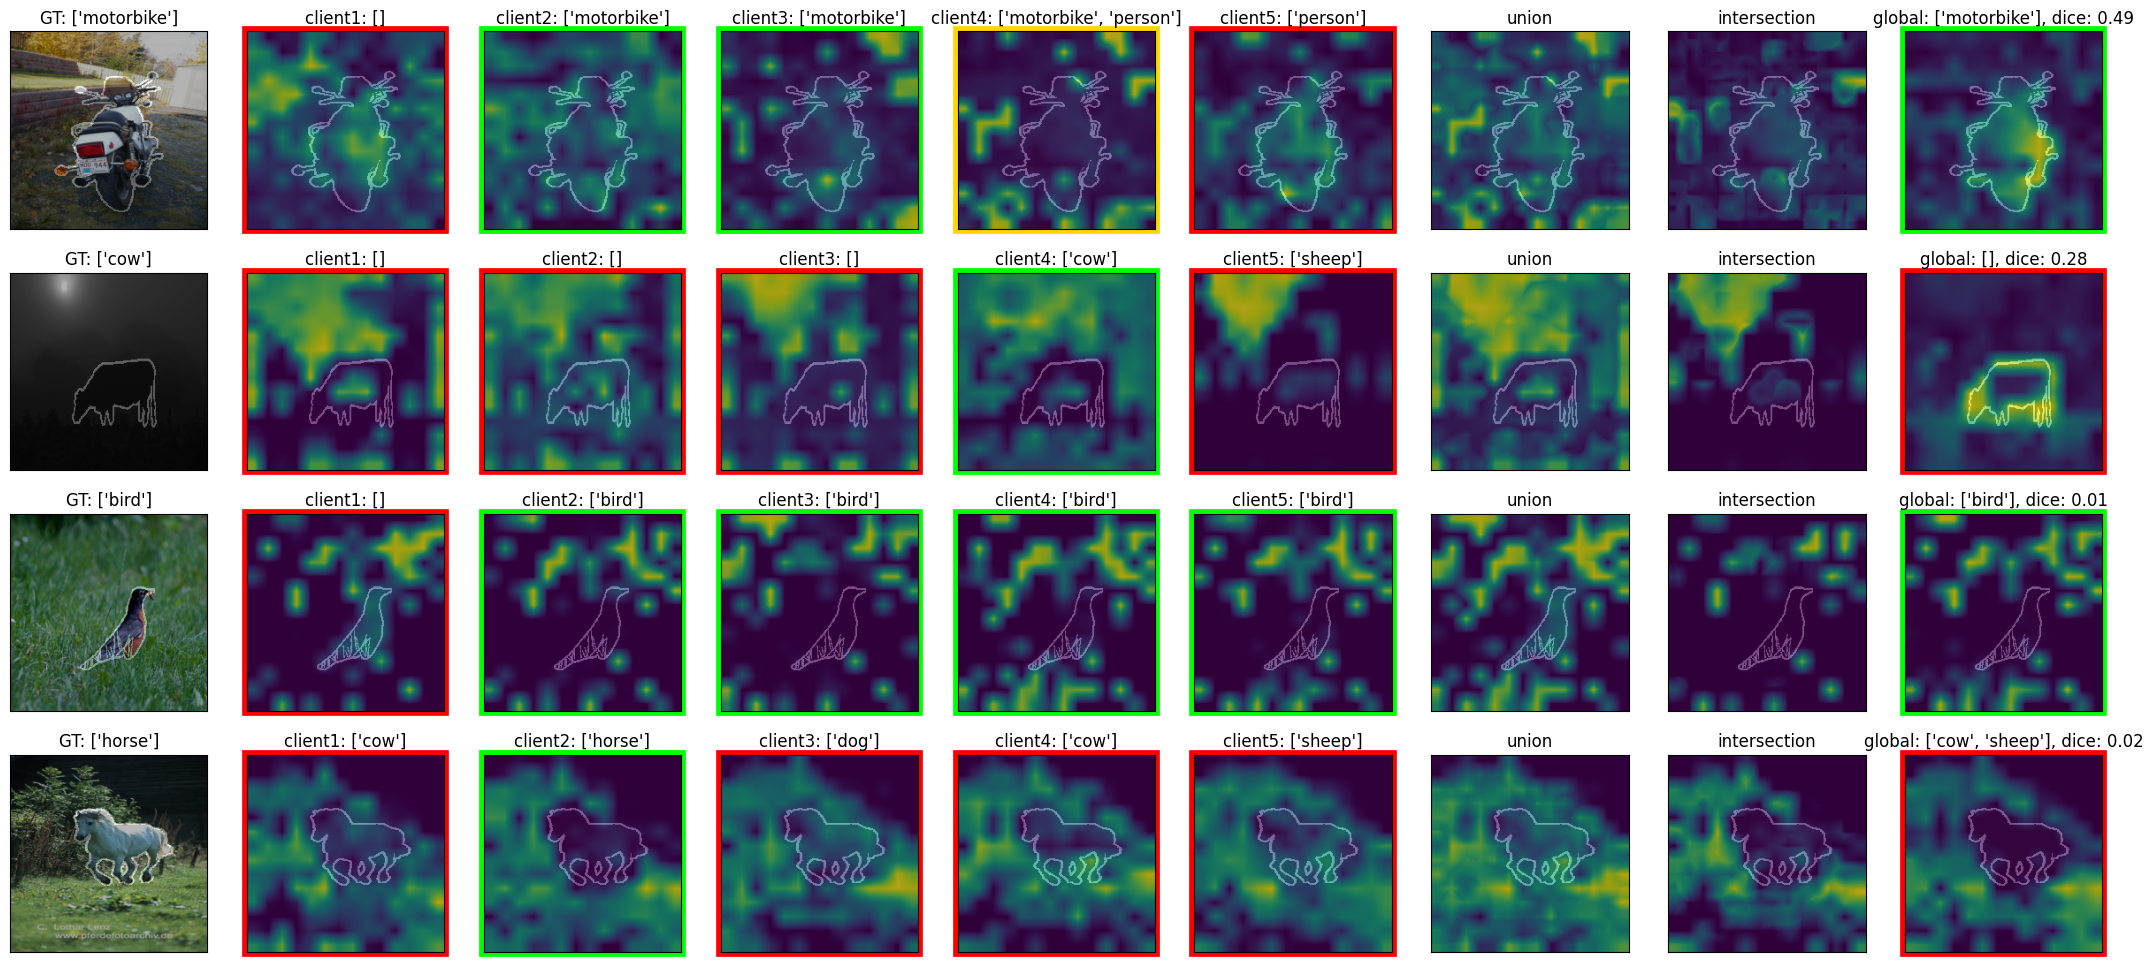

In [71]:
%matplotlib inline
def get_border_color(true_label, pred_label):
    if pred_label == true_label:
        return 'lime'  # green
    elif set(pred_label) & set(true_label):
        return 'gold'  # yellow
    else:
        return 'red'
image_index = [1, 4, 5, 8]
row = len(image_index)
col = 9
clients = 5
extra_plots = 3  # union, intersection, global

import matplotlib.pyplot as plt
plt.figure(figsize=(3 * col, 3 * row))

for j in range(row):
    idxImage = image_index[j]
    true_label = labels[idxImage]
    for i in range(clients + extra_plots + 1):
        ax = plt.subplot(row, col, j * col + i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        # print(i, idxImage)
        if i == 0:
            img = images[idxImage].cpu().permute(1, 2, 0)
            mask = masks[idxImage].cpu().permute(1, 2, 0)
            plt.imshow(img)
            plt.imshow(mask, alpha=0.3, cmap='gray')
            plt.title(f'GT: {true_label}')
        elif i <= clients:
            img = grad_cam_images[i - 1].cpu()[idxImage]
            pred_label = pred_labels[i - 1][idxImage]
            border_color = get_border_color(true_label, pred_label)
            plt.imshow(img)
            plt.imshow(mask, alpha=0.3, cmap='gray')
            # set border color
            ax.patch.set_edgecolor(border_color)
            ax.patch.set_linewidth(7)
            plt.title(f'client{i}: {pred_label}')
        elif i == clients + 1:
            img = union_cam.cpu()[idxImage]
            plt.imshow(img)
            plt.imshow(mask, alpha=0.3, cmap='gray')
            plt.title('union')
        elif i == clients + 2:
            img = intersection_cam.cpu()[idxImage]
            plt.imshow(img)
            plt.imshow(mask, alpha=0.3, cmap='gray')
            plt.title('intersection')
        elif i == clients + 3:
            img = central_grad_cam_image[idxImage]
            border_color = get_border_color(true_label, central_pred_labels[idxImage])
            plt.imshow(img)
            plt.imshow(mask, alpha=0.3, cmap='gray')
            plt.title(f'global: {central_pred_labels[idxImage]}, dice: {dice_scores[idxImage]:.2f}')
            ax.patch.set_edgecolor(border_color)
            ax.patch.set_linewidth(7)
        # plt.gca().set_xticks([])
        # plt.gca().set_yticks([])
        # plt.gca().spines['top'].set_visible(False)
        # plt.gca().spines['right'].set_visible(False)
        # plt.gca().spines['bottom'].set_visible(False)
        # plt.gca().spines['left'].set_visible(False)

plt.savefig('grad_cam2.png')
plt.show()
# plt.tight_layout()

In [72]:
mha_images = [] 
th_images = []
for model in models:
    mha, th = model.module.get_attention_maps_postprocessing_(images.cuda())
    mha_images.append(mha)
    th_images.append(th)
    
mha_images = torch.stack([torch.tensor(mha_images[i]) for i in range(len(mha_images))])
th_images = torch.stack([torch.tensor(th_images[i]) for i in range(len(th_images))])
mha_images.shape # n_clients * b * 224 * 224
th_images.shape # n_clients * b * 224 * 224
print(mha_images.shape, th_images.shape)


torch.Size([5, 10, 3, 224, 224]) torch.Size([5, 10, 3, 224, 224])


In [73]:
central_mha, central_th = central_model.module.get_attention_maps_postprocessing_(images.cuda())

In [74]:
central_mha = torch.tensor(central_mha)
central_mha_agg = []
for i in range(central_mha.shape[0]):
    central_mha_agg.append(torch.max(central_mha[i], dim=0)[0])
central_mha_agg = torch.stack(central_mha_agg)
central_mha_agg.shape

torch.Size([10, 224, 224])

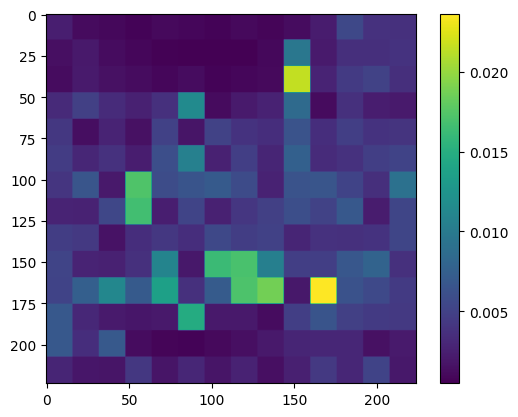

In [75]:
plt.imshow(central_mha_agg[2].cpu())
plt.colorbar()

In [76]:
mha_dice_scores = []
for i in range(10):
    central_mha_agg_ = torch.tensor(central_mha_agg[i] > torch.median(central_mha_agg[i])).unsqueeze(0).cpu()
    mask_img = masks[i].unsqueeze(0).cpu() > 0
    ds = dice_score(central_mha_agg_, mask_img)
    mha_dice_scores.append(ds)
mha_dice_scores

/tmp/ipykernel_295305/186807296.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  central_mha_agg_ = torch.tensor(central_mha_agg[i] > torch.median(central_mha_agg[i])).unsqueeze(0).cpu()


[tensor(0.3652),
 tensor(0.5620),
 tensor(0.0301),
 tensor(0.3816),
 tensor(0.3353),
 tensor(0.2017),
 tensor(0.6943),
 tensor(0.3125),
 tensor(0.3823),
 tensor(0.8043)]

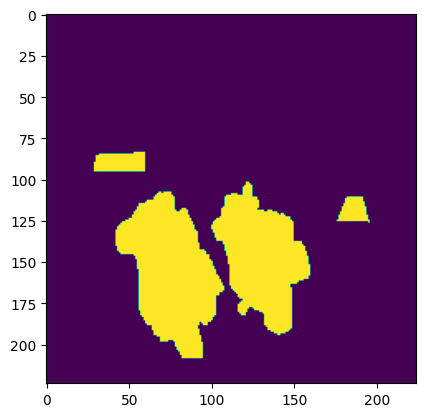

In [ ]:
# plt.imshow(masks[0].cpu().permute(1, 2, 0))
# plot image : masks > 0
plt.imshow(masks[0].cpu().permute(1, 2, 0) > 0)

In [ ]:
grad_cam_images[0]
np.median(grad_cam_images[0].cpu().numpy())

0.18511912

In [ ]:
grad_cam_images[0].shape

torch.Size([10, 224, 224])

[tensor(0.2681), tensor(0.9651), tensor(1.6597), tensor(0.2553), tensor(0.1943), tensor(0.5568), tensor(0.0537), tensor(0.3613), tensor(1.5300), tensor(1.5474)]


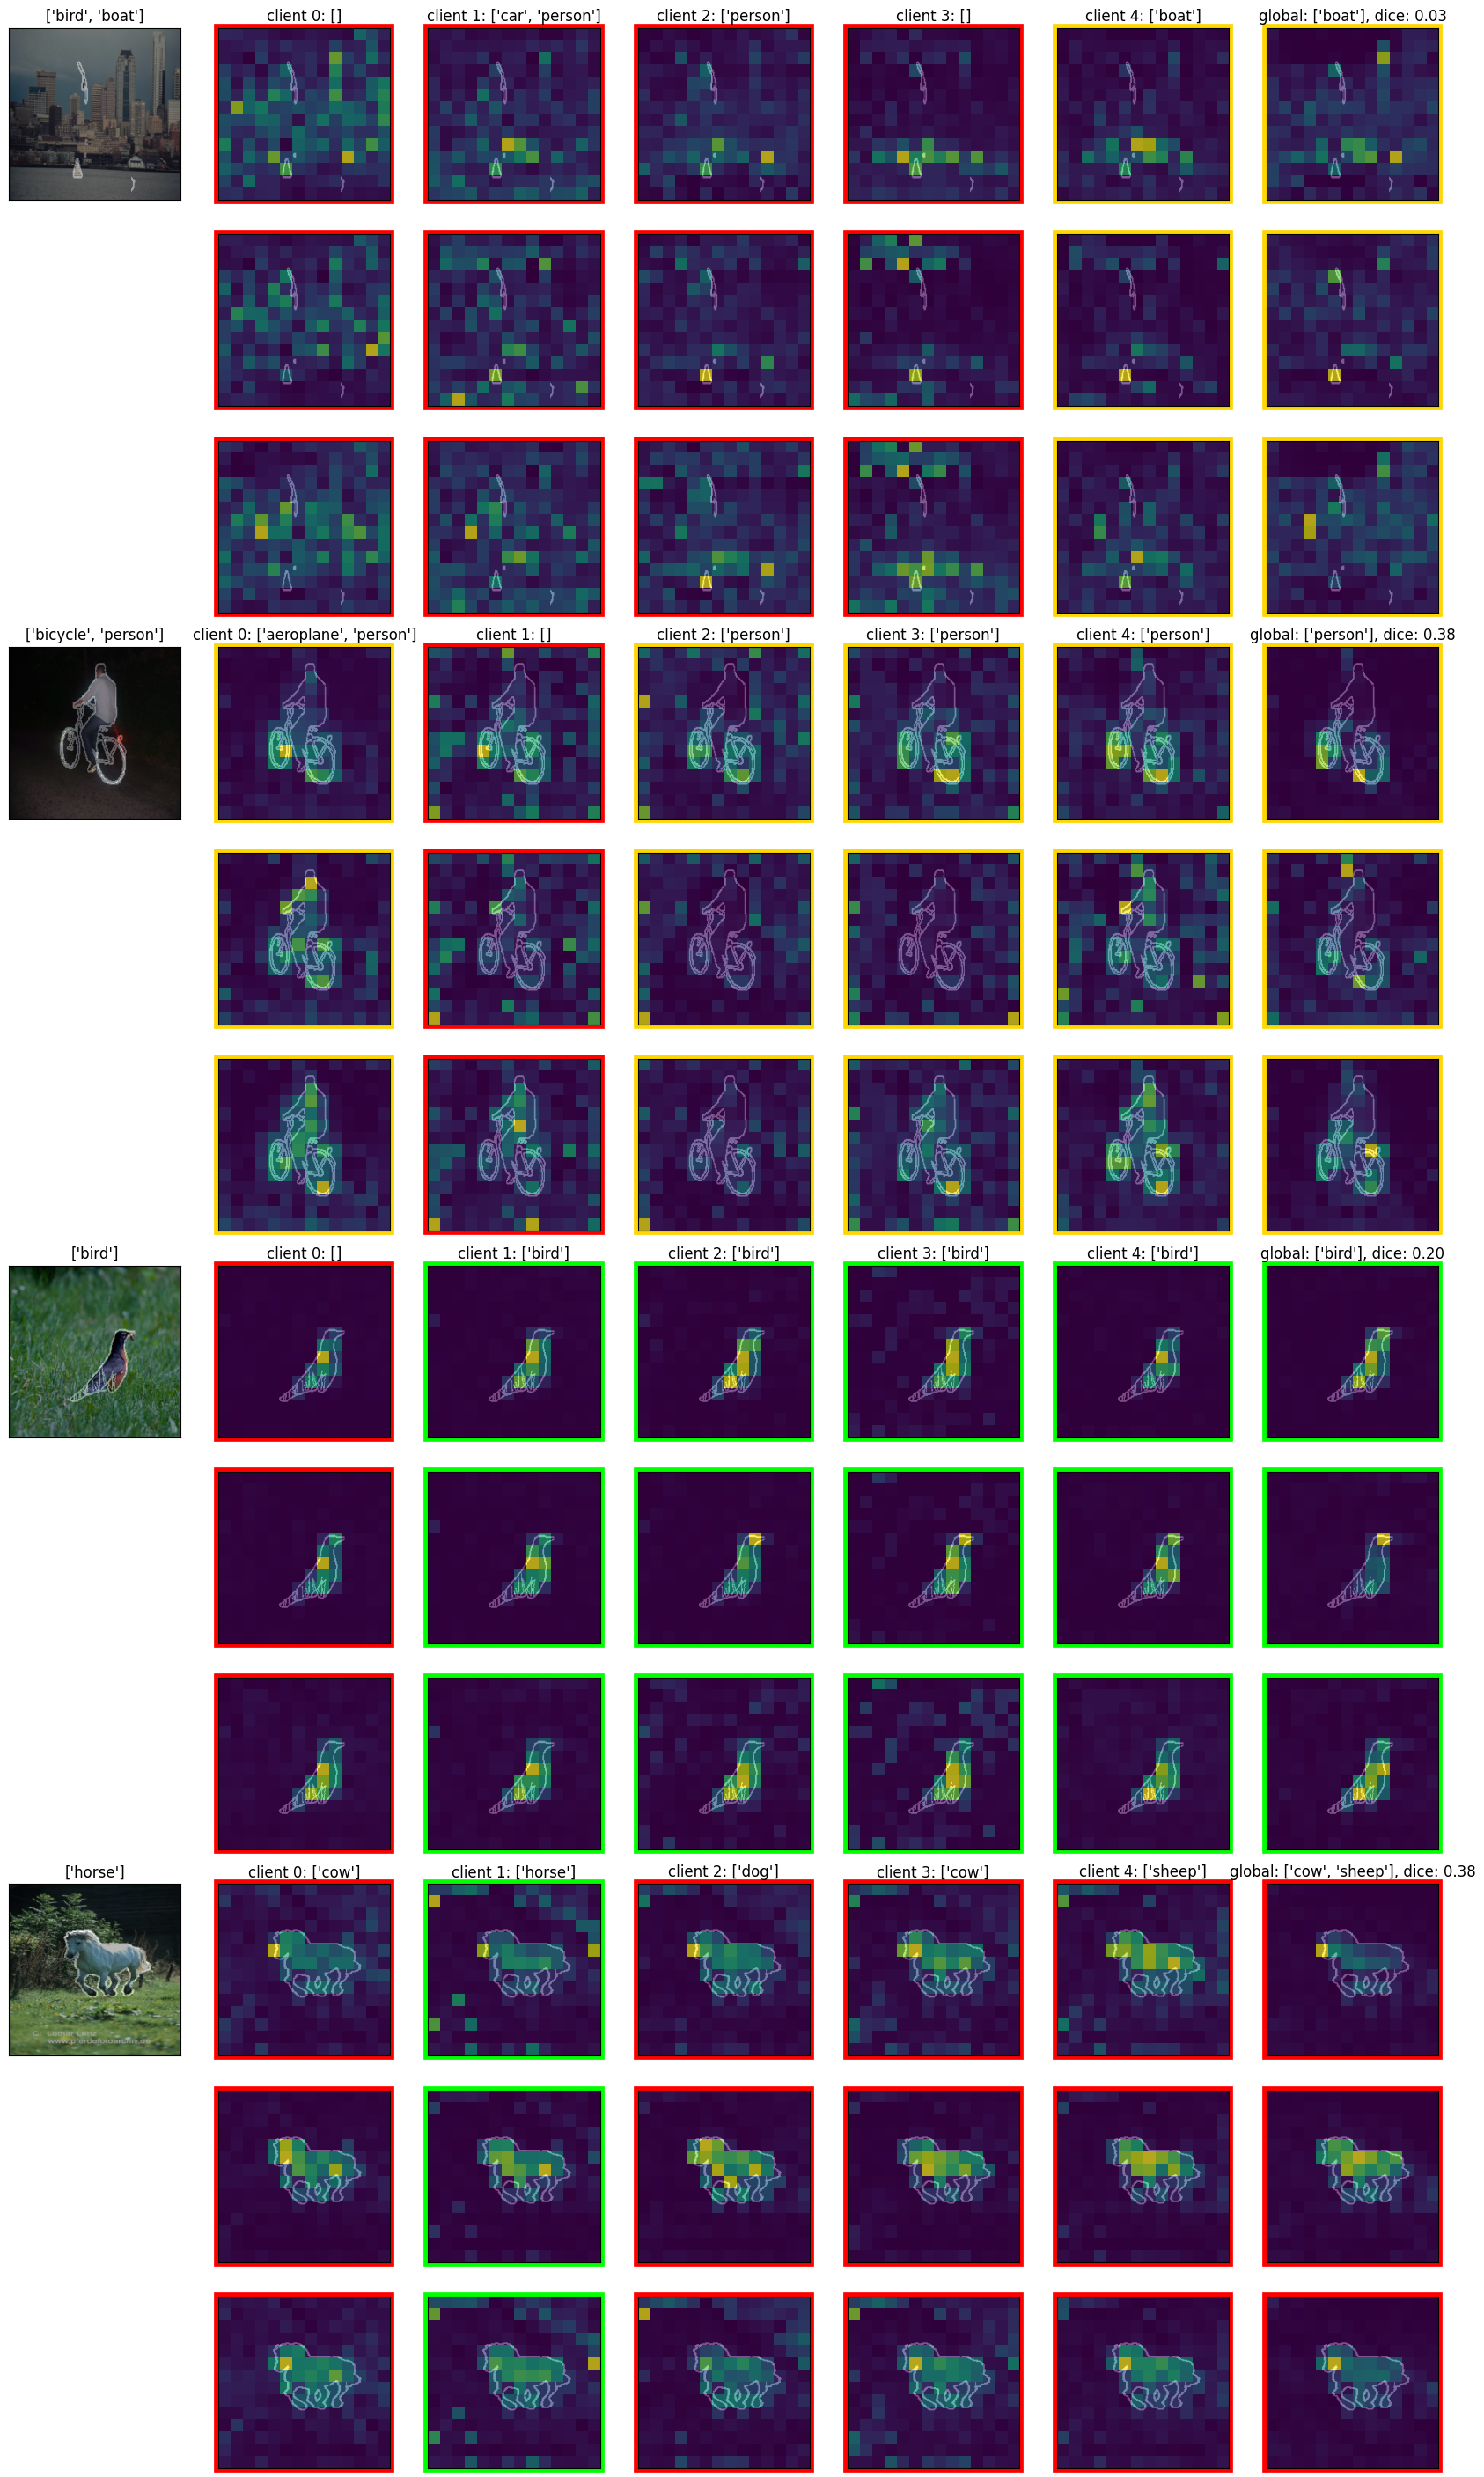

<Figure size 640x480 with 0 Axes>

In [77]:
def plot_mha_images(images, labels, mha_images, pred_labels, central_mha, central_pred_labels):
    n_clients, n_images, n_head, h, w = mha_images.shape
    image_indices = [2,3,5,8]
    row = len(image_indices) * n_head
    col = 1 + n_clients + 1
    plt.figure(figsize=(3 * col, 3 * row))
    for j in range(0, row):
        _j = j // n_head
        img_index = image_indices[_j]
        true_label = labels[img_index]
        k = j % n_head
        if k == 0:
            ax = plt.subplot(row, col, j * col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(images[img_index].numpy().transpose(1, 2, 0))
            plt.imshow(masks[img_index].numpy().transpose(1, 2, 0), alpha=0.3, cmap='gray')
            plt.title(true_label)
        for i in range(0, n_clients):
            ax = plt.subplot(row, col, j * col + i + 2)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(mha_images[i, img_index, k, :, :].numpy())
            plt.imshow(masks[img_index].numpy().transpose(1, 2, 0), alpha=0.3, cmap='gray')
            pred_label = pred_labels[i][img_index]
            border_color = get_border_color(true_label, pred_label)
            ax.patch.set_edgecolor(border_color)
            ax.patch.set_linewidth(7)
            if k == 0:
                plt.title(f'client {i}: {pred_label}')
        ax = plt.subplot(row, col, j * col + n_clients + 2)
        plt.imshow(central_mha[img_index, k, :, :])
        plt.imshow(masks[img_index].numpy().transpose(1, 2, 0), alpha=0.3, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        central_pred_label = central_pred_labels[img_index]
        border_color = get_border_color(true_label, central_pred_label)
        ax.patch.set_edgecolor(border_color)
        ax.patch.set_linewidth(7)

        if k == 0:
            plt.title(f'global: {central_pred_label}, dice: {mha_dice_scores[img_index]:.2f}')
    plt.savefig('mha_images.png')
    plt.show()
    plt.tight_layout()

# Usage
plot_mha_images(images, labels, mha_images, pred_labels, central_mha, central_pred_labels)